In [1]:
!apt-get install graphviz
!pip install torchview

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
import glob
import unicodedata
import string
import requests
import random
import sys
import torch
from torch.autograd import Variable
from torch import nn
from torchview import draw_graph
import random
import time
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Data Prep

### Download and Tensorify

In [3]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)
print(n_letters)
def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1 # one-hot-encoded representation
    return tensor

# Define the GitHub repository URL and branch
github_url = 'https://api.github.com/repos/DrUzair/NLP/contents/data/names'
branch = 'f8e0c40481b1c1e32440b1da39c8bdfc9f070ffa'

# Initialize dictionaries to store data
all_categories = []
category_lines = {}

# Make a request to the GitHub API to get the list of files in the directory
response = requests.get(f'{github_url}?ref={branch}')

if response.status_code == 200:
    file_data = response.json()

    for file_info in file_data:
        if file_info['type'] == 'file' and file_info['name'].endswith('.txt'):
            file_url = file_info['download_url']
            category = file_info['name'].split('.')[0]

            # Add the category to the list
            all_categories.append(category)

            # Make a request to download the file
            file_response = requests.get(file_url)

            if file_response.status_code == 200:
                # Read and store the file content
                lines = file_response.text.split('\n')
                category_lines[category] = lines
            else:
                print(f"Failed to download file: {file_info['name']}")
else:
    print(f"Failed to retrieve file list from GitHub: {response.status_code}")

n_categories = len(all_categories)

58


In [4]:
print(all_categories)
print(len(all_categories))

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
18


### Estimate base-line error

We have 18 classes.
The cross-entropy of a random classifier with 18 classes can be calculated using the formula:

$H(p,q)=−\sum_xp(x)\log⁡q(x)$


where $p(x)$ is the true probability distribution and $q(x)$ is the predicted probability distribution.

- In the case of a random classifier, the predicted probability distribution is uniform, i.e., $q(x) = 1/18$ for all $x$.

- In the context of classification, the true probability distribution is typically represented as a one-hot vector, where the probability of the true class is 1 and the probabilities of all other classes are 0. In this case, the true probability distribution would be a one-hot vector with 1 in one of the 18 positions and 0 in all other positions. In this case, $p(x) = 1$ for the true class and $p(x) = 0$ for all other classes.

Substituting these values, the summation in the formula reduces to:

$H(p,q)=−\sum_xp(x)\log⁡q(x)=−\log⁡q(x)=−log⁡\frac{1}{18}=\log18≈2.89$

In [ ]:
category_lines['Arabic']

### randomTrainingExample

In [6]:
def randomTrainingExample():
    category = all_categories[random.randint(0, len(all_categories) - 1)]
    category_names = category_lines[category]
    name = category_names[random.randint(0, len(category_names) - 1)]
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    name_tensor = Variable(lineToTensor(name))
    return category, name, category_tensor, name_tensor

category, name, category_tensor, name_tensor = randomTrainingExample()
print('category =', category, '/ name =', name, 'name_tensor shape', name_tensor.shape)

category = English / name = Travers name_tensor shape torch.Size([7, 1, 58])


## Define Model

This class defines a simple Multilayer Perceptron (MLP) neural network using PyTorch's `nn.Module` module. An MLP is a type of feedforward neural network, consisting of multiple layers of nodes (neurons), each connected to the next layer. The class is defined in Python and utilizes the PyTorch library.

Let's break down the key components of this class:

1. **Constructor (`__init__`) method:**
   - It takes three parameters: `input_dim`, `hidden_dim`, and `output_dim`, representing the dimensions of the input, hidden, and output layers, respectively.
   - Initializes three linear layers (`nn.Linear`): `fc1`, `fc2`, and `softmax`.
     - `fc1`: First fully connected (linear) layer mapping input_dim to hidden_dim.
     - `fc2`: Second fully connected (linear) layer mapping hidden_dim to output_dim.
     - `softmax`: Log-softmax activation function applied along dimension 1 (usually used for classification problems).

2. **Forward method (`forward`):**
   - It defines the forward pass of the network, describing how input data moves through the layers.
   - Takes an input tensor `x_in` of shape (batch_size, input_dim).
   - Applies the first linear layer (`fc1`) followed by a Rectified Linear Unit (ReLU) activation function (`F.relu`).
   - Applies the second linear layer (`fc2`) followed by another ReLU activation.
   - Applies the log-softmax activation (`softmax`) on the output.
   - Returns the final output tensor.

In summary, this MLP consists of an input layer (`fc1`), a hidden layer with a ReLU activation, and an output layer (`fc2`) with a log-softmax activation. The goal is to map input data (name) to a probability distribution over different classes (name language).

- Note that for binary classification, the output_dim would typically be set to 1, and a sigmoid activation might be used instead of softmax.

In [7]:
from torch import nn, sigmoid
import torch.nn.functional as F

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the output Linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.
        """
        hidden = F.relu(self.fc1(x_in))
        output = F.relu(self.fc2(hidden))
        output = self.softmax(output)
        return output

## Training

### categoryFromOutput

The function `categoryFromOutput(output)` is a utility function that takes the output tensor from the neural network and returns the predicted category.

- **Input:**
  - `output`: The output tensor from the neural network. It is assumed to be a PyTorch tensor.

- **Processing:**
  - `output.data`: Accesses the underlying tensor of the `output` variable.
  - `topk(1)`: Returns the indices of the top `k` elements along a specified dimension. In this case, it finds the index of the maximum element along dimension 1 (which typically corresponds to the classes in a classification problem).
  - `top_n, top_i`: Unpacks the result of `topk(1)`. `top_n` is the maximum value, and `top_i` is the index of the maximum value.

- **Output:**
  - `category_i`: Extracts the actual index of the predicted category from `top_i`.
  - `all_categories[category_i]`: Uses the index to look up the corresponding category label in the `all_categories` list.
  - Returns a tuple containing the predicted category label and its index.

`all_categories` is a list containing the category labels, and this function provides a convenient way to obtain the predicted category and its index from the network's output.

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)  # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

### Initialize model

In [9]:
n_hidden = 174
mlp = MultilayerPerceptron(input_dim=n_letters, hidden_dim=n_hidden, output_dim=n_categories)
#model_graph = draw_graph(mlp, input_size=(1, 58), device='meta')
#model_graph.visual_graph

In [10]:
learning_rate = 0.05 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()


def train(category_tensor, name_tensor):
    # step 1. zero the gradients
    optimizer.zero_grad()

    # step 2. compute the output
    output = mlp(name_tensor)

    # step 3. The loss is computed using
    loss = criterion(output, category_tensor)

    # step 4. The gradients of the loss are computed using
    loss.backward()

    # step 5. The weights of the MLP are updated using
    optimizer.step()

    return output, loss.item()

### training loop

1. The for loop iterates over a range of values from 1 to n_epochs + 1. In each iteration of the loop, a random training example is selected using the randomTrainingExample() function. This function returns the category and name of a random training example, as well as the corresponding category tensor and line tensor.
    
2. The name_tensor is a tensor representation of the name, and tensor_1d is a 1-dimensional tensor obtained by summing the line_tensor along the first dimension.

3. The train() function is called with the category_tensor and tensor_1d as inputs. This function returns the output of the model and the loss.
4. The current_loss variable is updated with the loss from the current iteration.
- If the current iteration is a multiple of print_every, the epoch number, loss, name, and guess are printed to the console. The guess is the predicted category for the current name, and correct is a string indicating whether the prediction was correct or not.
- If the current iteration is a multiple of plot_every, the current loss average is added to the list of losses, and current_loss is reset to 0.


5000 5% (0m 4s) 3.5021 Havlatova / Spanish ✗ (Czech)
10000 10% (0m 8s) 2.5231 Ngo / Korean ✗ (Vietnamese)
15000 15% (0m 12s) 3.0103 Félix / Irish ✗ (French)
20000 20% (0m 16s) 0.0219 Momotami / Japanese ✓
25000 25% (0m 21s) 3.5324 Hynna / Irish ✗ (Czech)
30000 30% (0m 25s) 0.8241 Ortega / Spanish ✓
35000 35% (0m 29s) 1.5866 Deforest / German ✗ (French)
40000 40% (0m 33s) 0.1675 Rompa / Dutch ✓
45000 45% (0m 37s) 4.4651 Miksatkova / Russian ✗ (Czech)
50000 50% (0m 41s) 0.0454 Kuai / Chinese ✓
55000 55% (0m 46s) 1.5685 Liatos / Spanish ✗ (Greek)
60000 60% (0m 50s) 1.4144 Nunes / Portuguese ✓
65000 65% (0m 54s) 2.2012 Pugliese / Greek ✗ (Italian)
70000 70% (0m 58s) 0.2067 Demas / Greek ✓
75000 75% (1m 3s) 0.7427 Baitchenko / Russian ✓
80000 80% (1m 7s) 0.0257 Babaev / Russian ✓
85000 85% (1m 11s) 1.2436 Vargas / Spanish ✗ (Portuguese)
90000 90% (1m 15s) 0.0292 Ryom / Korean ✓
95000 95% (1m 19s) 0.0002 Warszawski / Polish ✓
100000 100% (1m 24s) 0.5284 Hébert / French ✓
[2.8412782697975634,

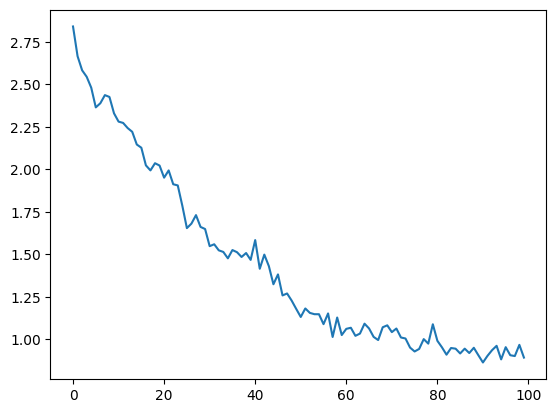

In [11]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

n_epochs = 100000
print_every = 5000
plot_every = 1000
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for epoch in range(1, n_epochs + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    name_tensor = name_tensor.sum(0)
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (
        epoch, epoch / n_epochs * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

torch.save(mlp, 'name-classifier.pt')

print(all_losses)
plt.figure()
plt.plot(all_losses)

## Evaluate

<ipython-input-12-ce8188bab30a>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-12-ce8188bab30a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


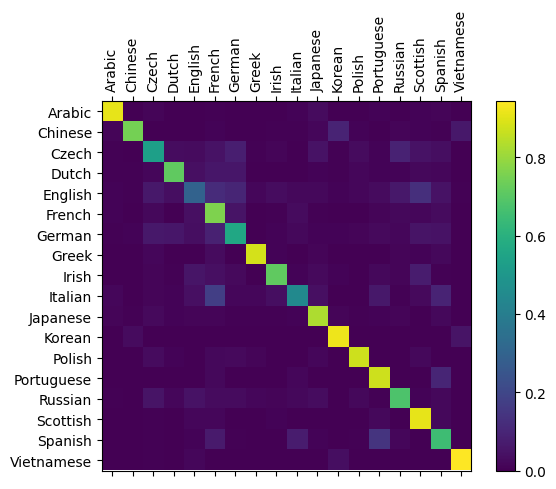

In [12]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#mlp = torch.load('./name-classifier.pt')

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000 # This is the number of examples that will be used to evaluate the performance of the model.

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    name_tensor = name_tensor.sum(0)
    if len(name) > 0:
      #print(name_tensor.shape)
      output = mlp(name_tensor)
      guess, guess_i = categoryFromOutput(output)
      #print(category, name, guess)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1
    else:
      continue
      # print(category, name)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Predict

In [32]:
mlp = torch.load('name-classifier.pt')

def predict(line, n_predictions=3):
    output = mlp(Variable(lineToTensor(line).sum(0)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

    return predictions


if __name__ == '__main__':
    predict('Uzair')


(-0.49) Spanish
(-1.96) Italian
(-2.18) Czech
